In [4]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import eli5

import regex as re
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import learning_curve

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from nltk.corpus import stopwords

import pickle
import sys

import warnings
warnings.filterwarnings('ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# df_reddit = pickle.load(open('../DataSet/df_reddit_for_model.pkl', 'rb'))
df_reddit = pickle.load(open('../DataSet/df_reddit_for_model.pkl', 'rb'))
EDA_df = pickle.load(open('../DataSet/EDA_all_for_model.pkl', 'rb'))
# df_reddit['target'] = df_reddit['subreddit'].replace({"NASA": 1, "Space_discussion": 0})
df_reddit.head(2)

,ent,text_merged,word_count*,sentiment_score*,target,polarity_score,polarity,polarity_VSA,lower_sent,tagged_sent,text_complexity
0,1,star shine saturn ring,4,0.0,1,0.0,1,1,star shine saturn ring,"[(star, NN), (shine, NN), (saturn, NN), (ring,...",92.80
1,2,smithsonian nation air space museum,5,0.0,1,0.0,1,1,smithsonian nation air space museum,"[(smithsonian, JJ), (nation, NN), (air, NN), (...",15.64


In [3]:
EDA_df.head(2)

,target,'',CC,CD,DT,EX,FW,IN,JJ,JJR,...,WP,WP$,WRB,ent,word_count*,sentiment_score*,polarity_score,polarity,polarity_VSA,text_complexity
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,4,0.0,0.0,1,1,92.80
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2,5,0.0,0.0,1,1,15.64


In [4]:
X = df_reddit['text_merged']
y = df_reddit['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify=y,
                                                    random_state = 101)

In [5]:
cvec = CountVectorizer(min_df=4, max_df=1.0,
                       ngram_range=(1,2),max_features = 3000)

term_mat = cvec.fit_transform(df_reddit['text_merged'])

term_df = pd.DataFrame(term_mat.toarray(), 
                       columns=cvec.get_feature_names())

term_df.head(2)

,aa,ab,abil,abl,abl see,aboard,aboard intern,aboard space,abort,abort test,...,york,youlikebet,young,youtu,zealand,zero,zero graviti,zone,zoom,zubrin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# for col in term_df.columns:
#     if col == 'target':
#         print(col)
term_df = term_df.drop(columns = ['target'])

In [7]:
All_DF =  pd.concat([EDA_df, term_df], axis=1)
All_DF.head(2)

,target,'',CC,CD,DT,EX,FW,IN,JJ,JJR,...,york,youlikebet,young,youtu,zealand,zero,zero graviti,zone,zoom,zubrin
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y2 = All_DF['target']
X2 = All_DF.drop(columns = ['target'])

X_arr2 = np.array(X2)
y_arr2 = np.array(y2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_arr2,
                                                        y_arr2,
                                                        test_size = 0.25,
                                                        random_state = 101)

### Hard voting

In [9]:
clf1 = LogisticRegression(solver='sag', max_iter=1000, n_jobs=-1)

clf2 = MLPClassifier(hidden_layer_sizes=50, activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)

clf3 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=6, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None,
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)


eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
        voting='hard', n_jobs=-1, verbose=True)

eclf1 = eclf1.fit(X_arr2, y_arr2)
# print(eclf1.predict(X_arr2))

train score 0.922
test score 0.9216666666666666


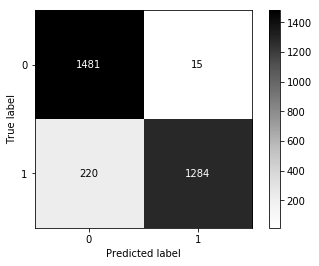

In [10]:
eclf1.score(X_train2, y_train2); 
print('train score', eclf1.score(X_train2, y_train2))

eclf1.score(X_test2, y_test2); 
print('test score', eclf1.score(X_test2, y_test2))

preds = eclf1.predict(X_test2)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test2, preds).ravel()

# View confusion matrix

plot_confusion_matrix(eclf1, X_test2, y_test2, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_03_1.png")

### Soft voting

In [11]:
clf1 = LogisticRegression(solver='sag', max_iter=1000, n_jobs=-1)

clf2 = MLPClassifier(hidden_layer_sizes=50, activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)

clf3 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                    n_estimators=100, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=6, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None,
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)


eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
        voting='soft', n_jobs=-1, verbose=True)

eclf1 = eclf1.fit(X_arr2, y_arr2)
# print(eclf1.predict(X_arr2))

train score 0.9607777777777777
test score 0.9646666666666667


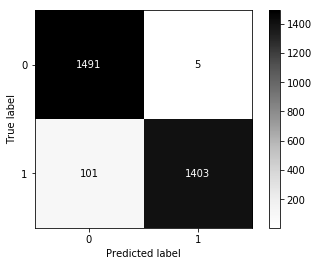

In [12]:
eclf1.score(X_train2, y_train2); 
print('train score', eclf1.score(X_train2, y_train2))

eclf1.score(X_test2, y_test2); 
print('test score', eclf1.score(X_test2, y_test2))

preds = eclf1.predict(X_test2)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test2, preds).ravel()

# View confusion matrix

plot_confusion_matrix(eclf1, X_test2, y_test2, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_03_2.png")

Changing hyperparameters with more depth and iteration to see if it will affect the results.

In [13]:
clf1 = LogisticRegression(solver='sag', max_iter=2500, n_jobs=-1)

clf2 = MLPClassifier(hidden_layer_sizes=50, activation='relu', solver='adam', 
                    alpha=0.0001, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                    n_iter_no_change=10, max_fun=15000)

clf3 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                    n_estimators=150, subsample=1.0, criterion='friedman_mse', 
                                    min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                    max_depth=5, min_impurity_decrease=0.0, min_impurity_split=None, 
                                    init=None, random_state=None, max_features=None,
                                    max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, 
                                    n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)


eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
        voting='soft', n_jobs=-1, verbose=True)

eclf1 = eclf1.fit(X_arr2, y_arr2)

train score 0.9587777777777777
test score 0.9563333333333334


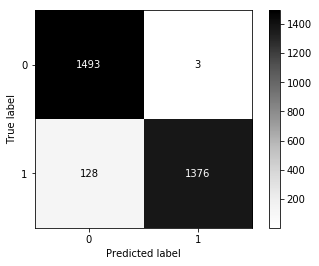

In [14]:
eclf1.score(X_train2, y_train2); 
print('train score', eclf1.score(X_train2, y_train2))

eclf1.score(X_test2, y_test2); 
print('test score', eclf1.score(X_test2, y_test2))

preds = eclf1.predict(X_test2)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test2, preds).ravel()

# View confusion matrix

plot_confusion_matrix(eclf1, X_test2, y_test2, 
                      cmap='Greys', values_format='d');
Accuracy = (tp + tn) / (tp + tn + fp + fn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)

Accuracy, Precision, Recall
plt.savefig("../Figures/plot_04_03_3.png")

The final result is a Soft voting model including LogisticRegression, MLPClassifier, and GradientBoostingClassifier with almost 96% accuracy. The ALL data was used which is included countvectorized data along with EDA.

Here I make a dictionary of models along with data type which were used in part 4 of this study.

In [15]:
model_names = {0:'LogisticRegression',
               1:'GradientBoostingClassifier',
               2:'MLPClassifier',
               3:'LogisticRegression',
               4:'LogisticRegression',
               5:'GradientBoostingClassifier',
               6:'GradientBoostingClassifier',
               7:'MLPClassifier',
               8:'MLPClassifier',
               9:'LogisticRegression',
               10:'MLPClassifier',
               11:'GradientBoostingClassifier',
               12:'Hard_voting_lr_GB_MLP',
               13:'Soft_voting_lr_GB_MLP',
               14:'Soft_voting_lr_GB_MLP_different_HP'
              }
data_details = {0:'CountVectorizer',
                1:'CountVectorizer',
                2:'CountVectorizer',
                3:'EDA_df',
                4:'EDA_df_normalized',
                5:'EDA_df',
                6:'EDA_df_normalized',
                7:'EDA_df',
                8:'EDA_df_normalized',
                9:'All_DF',
                10:'All_DF',
                11:'All_DF',
                12:'All_DF',
                13:'All_DF',
                14:'All_DF'
               }

accuracys = {0: 0.756,
             1: 0.736,
             2: 0.752,
             3:0.82,
             4:0.832,
             5:0.831,
             6:0.831,
             7:0.824,
             8:0.832,
             9:0.828,
             10:0.844,
             11:0.878,
             12:0.921,
             13:0.954,
             14:0.959
             
            }

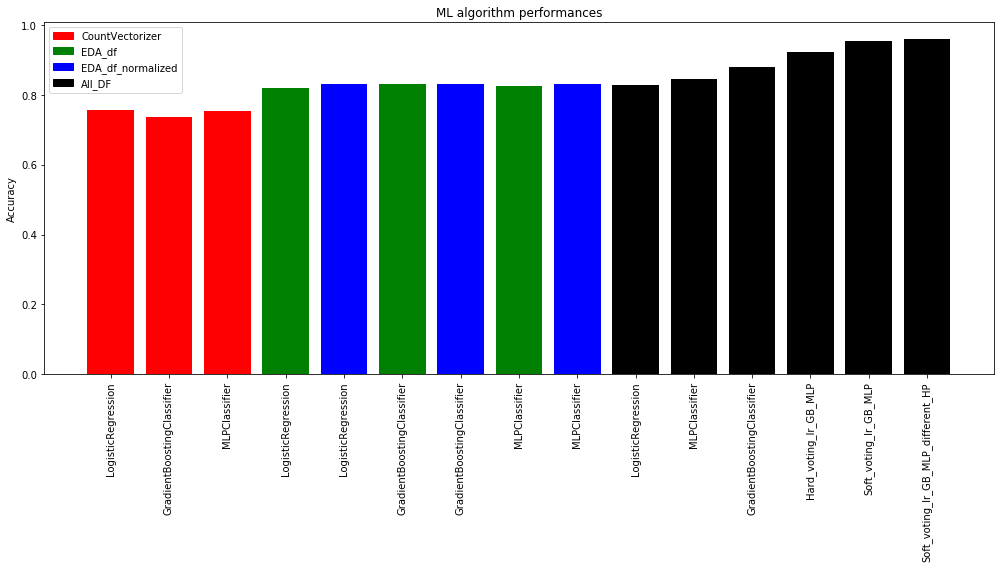

<Figure size 432x288 with 0 Axes>

In [13]:
# Choose the height of the bars
height = [0.756,0.736,0.752,0.82,
          0.832,0.831,0.831,0.824,
          0.832,0.828,0.844,0.878,
          0.921,0.954,0.959]

# Choose the names of the bars
bars = ('LogisticRegression','GradientBoostingClassifier','MLPClassifier',
       'LogisticRegression','LogisticRegression','GradientBoostingClassifier',
       'GradientBoostingClassifier','MLPClassifier','MLPClassifier',
       'LogisticRegression','MLPClassifier','GradientBoostingClassifier',
       'Hard_voting_lr_GB_MLP','Soft_voting_lr_GB_MLP','Soft_voting_lr_GB_MLP_different_HP')
x_pos = np.arange(len(bars))


fig = plt.figure(figsize=(14,8))

# Create bars
my_colors=['r','r','r', 
           'g', 'b','g', 'b', 'g', 'b',
           'k', 'k','k','k','k','k']


plt.bar(x_pos, height, color=my_colors)

# Create names on the x-axis

plt.xticks(x_pos, bars); plt.xticks(rotation = 90)
plt.title('ML algorithm performances'); plt.ylabel('Accuracy')

colors = {'CountVectorizer':'red', 'EDA_df':'green',
          'EDA_df_normalized':'blue', 'All_DF':'black'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
# plt.tight_layout()
# plt.gcf().subplots_adjust(bottom=0.15)
# plt.autoscale()
fig.tight_layout()
plt.show()
plt.savefig("../Figures/plot_04_03_4.png"); 